In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
from tqdm.notebook import tqdm_notebook
from tabulate import tabulate
import itertools

In [4]:
source_path = '<Dataset Folder Path>'
os.chdir(source_path)
os.listdir()

['pb_train', 'pb_test', 'yt_test', 'abc2.csv', 'results']

In [5]:
pb_train_path = source_path + 'pb_train/'
pb_test_path = source_path + 'pb_test/'
yt_test_path = source_path + 'yt_test/'

# Get all the training/test csv file names
language_file_names = [f for f in os.listdir(pb_train_path) if f.endswith('.csv')]
languages = [f[:3] for f in language_file_names] ## Names of all the language classes
print(languages)

['odi', 'kan', 'mar', 'hin', 'asm', 'mal', 'pun', 'tam', 'tel', 'eng', 'ben', 'guj']


## Loading Prasar Bharti Training, Test as well as Youtube Test datasets

In [6]:
# training dataset
os.chdir(pb_train_path)
train_df_list = [pd.read_csv(f,header=None,encoding='UTF-16') for f in language_file_names] # list of dataframes of each language
os.chdir(source_path)

# test dataset
os.chdir(pb_test_path)
pb_test_df_list = [pd.read_csv(f,header=None,encoding='UTF-16') for f in language_file_names] # list of dataframes of each language
os.chdir(source_path)

# Yt test dataset
os.chdir(yt_test_path)
yt_test_df_list = [pd.read_csv(f,header=None,encoding='UTF-16') for f in language_file_names] # list of dataframes of each language
os.chdir(source_path)

In [7]:
# combined true labels for these data
y_train = [] # true labels
for i in range(len(train_df_list)):
    for _ in range(len(train_df_list[i])):
        y_train.append(i)

# pb_test
y_pb_test = []
for i in range(len(pb_test_df_list)):
    for _ in range(len(pb_test_df_list[i])):
        y_pb_test.append(i)

# yt_test
y_yt_test = []
for i in range(len(yt_test_df_list)):
    for _ in range(len(yt_test_df_list[i])):
        y_yt_test.append(i)



### Min-Max Normalisation

In [8]:
## normalise the data samples in range [0, 1]
# before feeding to model
train_min_max_list = [[df.min(), df.max()] for df in train_df_list] # storing min and max value for training data samples, for all the features

def normalise_df(df, minimums, maximums):
  normalised_ = (df - minimums)/(maximums - minimums)
  return normalised_

In [9]:
# Prasar Bharti Training Dataset
normalised_train_df_list = [normalise_df(train_df_list[i], train_min_max_list[i][0], train_min_max_list[i][1]) for i in range(len(train_df_list))]

# Prasar Bharti Test Dataset
normalised_pb_test_df_list = [normalise_df(pb_test_df_list[i], train_min_max_list[i][0], train_min_max_list[i][1]) for i in range(len(pb_test_df_list))]

# YouTube Test Dataset
normalised_yt_test_df_list = [normalise_df(yt_test_df_list[i], train_min_max_list[i][0], train_min_max_list[i][1]) for i in range(len(yt_test_df_list))]

In [21]:
## combine all normalised training DataFrames into one
combined_train_df = pd.concat(normalised_train_df_list,axis=0)

## 1. Classification using GMM

In [10]:
def GMM_load_trained_model(model_type, n_comps, cov_type, class_label):
  '''
    model_type: str -> {GMM or UBM-GMM}
    n_comps: int -> no. of components
    cov_type: str -> {diag or full}
    class_label: str -> languages ...
  '''
  filepath = f'results/{model_type}_{cov_type}_{n_comps}_{class_label}.pickle'
  model = pickle.load(open(source_path + filepath, 'rb'))
  return model

In [11]:
def GMM_training_single(train_df, n_comps, cov_type, class_label, random_seed = 42, model_type = "GMM"):
  filepath = f'results/{model_type}_{cov_type}_{n_comps}_{class_label}.pickle'

  if os.path.exists(source_path + filepath):
    return GMM_load_trained_model(model_type, n_comps, cov_type, class_label)

  # initialising gmm model
  model = GaussianMixture(n_components=n_comps, covariance_type=cov_type, random_state=random_seed, init_params='k-means++')
  # fitting the model with training data
  model.fit(train_df.values)

  # dumping/saving trained model
  pickle.dump(model, open(source_path + filepath, 'wb'))
  return model  # --> successful

In [12]:
def GMM_training_all(train_dfs, n_comps, cov_type, random_seed = 42):
  gmm_lists = []
  for i in tqdm_notebook(range(len(train_dfs)), desc="model training loop"):
    curr_model = GMM_training_single(train_dfs[i], n_comps, cov_type, languages[i])
    gmm_lists.append(curr_model)
  # print(f'********** training complete for ${cov_type} covariance with ${n_comps} components ******')
  return gmm_lists  


#### Prior probabilities of each class

In [13]:
# prior (training) log probabilities for each classes
total_samples = 0
for i, df in enumerate(train_df_list):
  total_samples += len(df)

priors = [len(train_df_list[i])/total_samples for i in range(len(train_df_list))]
log_priors = [np.log(prob) for prob in priors]

In [14]:
def GMM_prediction(gmm_lists, test_df_list, y_test):
    '''This Function takes 
      gmm_lists :-> list of models of each class,
      test_df_list :-> list of test DataFrames,
      y_test :-> combined true test labels as input'''
    
    ## Before calculating log probabilities we need to combine all the data_frames on top of each other in one csv file
    #     concatenating df1 and df2 along rows
    #     vertical_concat = pd.concat([df1, df2], axis=0)
    test = pd.concat(test_df_list, axis=0)
    
    ## weightage log likelihood using gmm.score_samples(x)
    log_lists = [gmm.score_samples(test.values) for gmm in gmm_lists]
    
    ## Now predicting output based on build model
    y_pred = [] #predicted labels based on our model
    for i in range(len(test)):
        # we need to find argmax such that log probability is maximum
        index_of_log_max = 0
        for j in range(len(log_lists)):
            if(log_lists[j][i] + log_priors[j] > log_lists[index_of_log_max][i] + log_priors[index_of_log_max]):
                index_of_log_max = j
        y_pred.append(index_of_log_max)
    
    return y_test, y_pred
    

## 2. UBM-GMM implementation functions

In [19]:
def MAP_adapt(universal_gmm, train_df, cov_type, n_comps, class_label, max_iter=100, r=0.7, model_type = "UBM-GMM"):
  '''
    universal_gmm:-> gmm built on top of all the data combined
    train_df:-> DataFrame of a single language
    ---- will help in model saving
    cov_type:-> {diag or full} 
    n_comps:-> #clusters
    class_label:-> language of train_df
  '''
  filepath = f'results/{model_type}_{cov_type}_{n_comps}_{class_label}.pickle'
  if os.path.exists(source_path + filepath):
    return GMM_load_trained_model(model_type, n_comps, cov_type, class_label)

  # copy the initial model
  gmm = copy.deepcopy(universal_gmm)
  X = train_df # refrence not copy
  
  ## MAP Adaptation for means    
  for i in range(max_iter):
      n = np.sum(gmm.predict_proba(X), axis=0).reshape(-1, 1) # shape = (K, 1)
      X_tilde = (1 / n) * gmm.predict_proba(X).T.dot(X) # shape = (K, d) --> K = num_component
      alpha = (n / (n + r)).reshape(-1, 1) # shape = (K, 1)
      gmm.means_ = alpha * X_tilde + (1 - alpha) * gmm.means_

  # dumping/saving trained model
  pickle.dump(gmm, open(source_path + filepath, 'wb'))
  return gmm  # --> successful

In [20]:
def UBM_GMM_training_all(combined_df, train_dfs, n_comps, cov_type):
  ubm_gmm = GMM_training_single(combined_df, n_comps, cov_type, 'overall',
                                model_type = "UBM-GMM")
  class_specific_gmm = []
  for i in tqdm_notebook(range(len(train_dfs)), desc='specific gmm progress'):
      lang_i_gmm = MAP_adapt(ubm_gmm, train_dfs[i].values, cov_type, n_comps, languages[i])
      class_specific_gmm.append(lang_i_gmm)
  return class_specific_gmm      


### Plot confusion Matrix

In [39]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=10): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # overall accuracy
  true_cls = 0
  for i in range(cm.shape[0]):
    true_cls += cm[i][i]
  acc_all = (true_cls/len(y_true))*100

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  # fig.colorbar(cax) # for now skip plotting heat index

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes 
  ax.set(title=f"Confusion Matrix\naccuracy: {acc_all :.2f}",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} \n({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

### Loading pre-trained models

---

The idea is to do comparision of models with diagonal covariance matrix first for both the systems:
1.  GMM
2.  UBM-GMM

Then repeat the same for full covariance matrix

#### Case 1(a): GMM with diagonal covariance




In [17]:
# Loading model for GMM with diagonal covariance matrix
accuracy_pb_test = []
accuracy_yt_test = []

# list of num_clusters
no_of_clusters = [2, 3, 4, 5, 7, 10, 12, 17]

for i in tqdm_notebook(range(len(no_of_clusters)), desc="outer loop for components"):
    curr_gmm_lists = GMM_training_all(normalised_train_df_list, no_of_clusters[i], 'diag')

    # prediction for pb_test
    test_label, pred_label_pb = GMM_prediction(curr_gmm_lists, normalised_pb_test_df_list, y_pb_test)
    acc_pb_test = 100*accuracy_score(test_label, pred_label_pb)
    accuracy_pb_test.append(acc_pb_test)

    # prediction for yt_test
    test_label, pred_label_yt = GMM_prediction(curr_gmm_lists, normalised_yt_test_df_list, y_yt_test)
    acc_yt_test = 100*accuracy_score(test_label, pred_label_yt)
    accuracy_yt_test.append(acc_yt_test)
    # break

outer loop for components:   0%|          | 0/8 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

In [18]:
print('************ Tabulating results for GMM with diagonal covariance matrix ************')
results_ = { "num_clusters": no_of_clusters, "pb_test_acc(%)": accuracy_pb_test, 
            "yt_test_acc(%)": accuracy_yt_test }
print(tabulate(results_, headers="keys", tablefmt="grid"))

************ Tabulating results for GMM with diagonal covariance matrix ************
+----------------+------------------+------------------+
|   num_clusters |   pb_test_acc(%) |   yt_test_acc(%) |
+================+==================+==================+
|              2 |          70.7749 |          63.4831 |
+----------------+------------------+------------------+
|              3 |          71.7137 |          64.7694 |
+----------------+------------------+------------------+
|              4 |          72.7805 |          65.01   |
+----------------+------------------+------------------+
|              5 |          73.5376 |          65.3206 |
+----------------+------------------+------------------+
|              7 |          75.1803 |          68.5969 |
+----------------+------------------+------------------+
|             10 |          75.7624 |          68.0386 |
+----------------+------------------+------------------+
|             12 |          76.4082 |          67.4518 |
+--

#### Case 1(b): UBM-GMM with diagonal covariance

In [23]:
accuracy_ubm_pb_test = []
accuracy_ubm_yt_test = []

# list of num_clusters
no_of_clusters_ubm = [2, 3, 4, 5, 7, 10, 12, 17]

for i in tqdm_notebook(range(len(no_of_clusters_ubm)), desc="outer loop ubm components"):
    curr_gmm_lists = UBM_GMM_training_all(combined_train_df, normalised_train_df_list, no_of_clusters_ubm[i], 'diag')

    # prediction for pb_test
    test_label, pred_label_pb_ubm_diag = GMM_prediction(curr_gmm_lists, normalised_pb_test_df_list, y_pb_test)
    acc_pb_test = 100*accuracy_score(test_label, pred_label_pb_ubm_diag)
    accuracy_ubm_pb_test.append(acc_pb_test)

    # prediction for yt_test
    test_label, pred_label_yt_ubm_diag = GMM_prediction(curr_gmm_lists, normalised_yt_test_df_list, y_yt_test)
    acc_yt_test = 100*accuracy_score(test_label, pred_label_yt_ubm_diag)
    accuracy_ubm_yt_test.append(acc_yt_test)
    # break


outer loop ubm components:   0%|          | 0/8 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

In [24]:
print('************ Tabulating results for UBM-GMM with diag covariance matrix ************')
results_ = {"num_clusters": no_of_clusters_ubm, "pb_test_acc(%)": accuracy_ubm_pb_test, 
            "yt_test_acc(%)": accuracy_ubm_yt_test}
print(tabulate(results_, headers="keys", tablefmt="grid"))

************ Tabulating results for UBM-GMM with diag covariance matrix ************
+----------------+------------------+------------------+
|   num_clusters |   pb_test_acc(%) |   yt_test_acc(%) |
+================+==================+==================+
|              2 |          69.8485 |          67.1398 |
+----------------+------------------+------------------+
|              3 |          68.6063 |          64.6378 |
+----------------+------------------+------------------+
|              4 |          70.6412 |          66.618  |
+----------------+------------------+------------------+
|              5 |          70.766  |          66.1372 |
+----------------+------------------+------------------+
|              7 |          71.7684 |          67.4771 |
+----------------+------------------+------------------+
|             10 |          72.2203 |          66.4376 |
+----------------+------------------+------------------+
|             12 |          72.8551 |          66.2659 |
+--

---
We can see that both the models have similar accuracies on test datasets for same number of clustors. However, in some cases ```simple GMM``` outperforms ```UBM-GMM```.

Let's plot two graphs for better comparision:
1.  Accuracy vs No. of mixtures

2. Confusion Matrix for each of the subcases

---

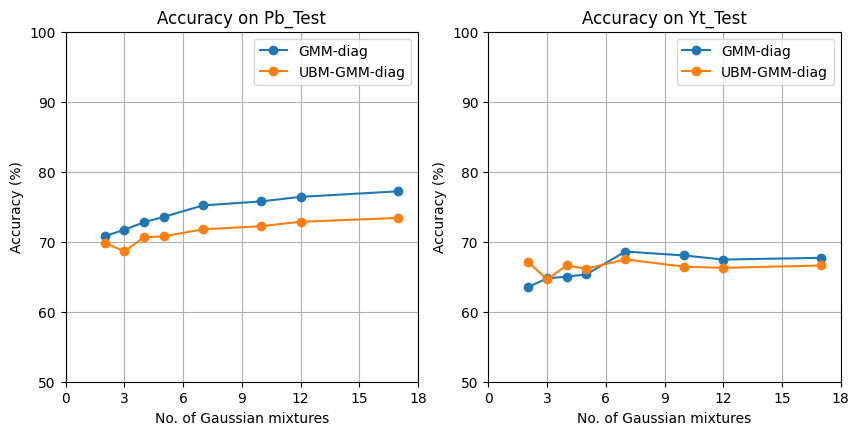

In [35]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.plot(no_of_clusters, accuracy_pb_test, marker='o',label='GMM-diag')
plt.plot(no_of_clusters_ubm, accuracy_ubm_pb_test, marker='o', label='UBM-GMM-diag')
ax.set(title=f"Accuracy on Pb_Test",
         xlabel="No. of Gaussian mixtures",
         ylabel="Accuracy (%)")
plt.grid()
plt.legend()
plt.yticks(range(50, 101, 10))
plt.xticks(range(0, no_of_clusters[-1]+3, 3))
# yt_test
ax = plt.subplot(2, 2, 2)
plt.plot(no_of_clusters, accuracy_yt_test, marker='o',label='GMM-diag')
plt.plot(no_of_clusters_ubm, accuracy_ubm_yt_test, marker='o', label='UBM-GMM-diag')
ax.set(title=f"Accuracy on Yt_Test",
         xlabel="No. of Gaussian mixtures",
         ylabel="Accuracy (%)")
plt.xticks(range(0, no_of_clusters[-1]+3, 3))

plt.yticks(range(50, 101, 10))
plt.grid()
plt.legend()
plt.show()

         |****** Performance of GMM with Diagonal Covariance on Pb_Test *******************| 


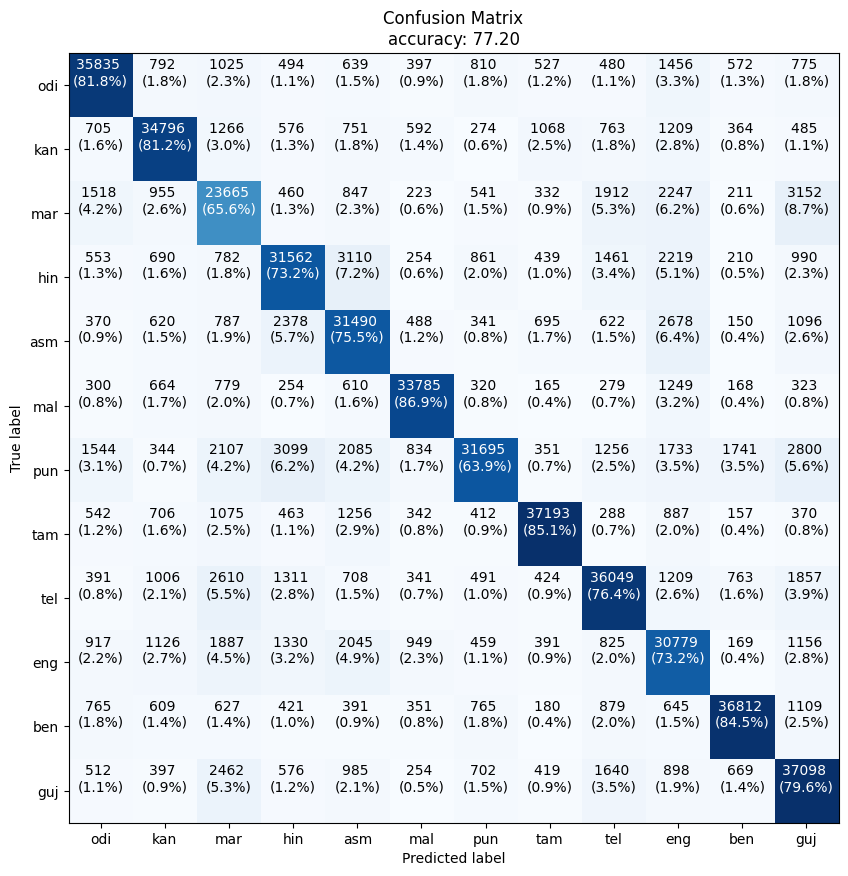

In [44]:
print('         |****** Performance of GMM with Diagonal Covariance on Pb_Test *******************| ')
make_confusion_matrix(y_pb_test, pred_label_pb, classes=languages, figsize=(10, 10)) # plot confusion matrix for bestmodel

#### Case 2(a): GMM with full covariance




In [46]:
accuracy_full_pb_test = []
accuracy_full_yt_test = []

# list of num_clusters
no_of_clusters_full = [2, 3, 4, 5, 7, 10]

for i in tqdm_notebook(range(len(no_of_clusters_full)), desc="outer loop for n_components"):
    curr_gmm_lists = GMM_training_all(normalised_train_df_list, no_of_clusters_full[i], 'full')

    # prediction for pb_test
    test_label, pred_label_full_pb = GMM_prediction(curr_gmm_lists, normalised_pb_test_df_list, y_pb_test)
    acc_pb_test = 100*accuracy_score(test_label, pred_label_full_pb)
    accuracy_full_pb_test.append(acc_pb_test)

    # prediction for yt_test
    test_label, pred_label_full_yt = GMM_prediction(curr_gmm_lists, normalised_yt_test_df_list, y_yt_test)
    acc_yt_test = 100*accuracy_score(test_label, pred_label_full_yt)
    accuracy_full_yt_test.append(acc_yt_test)
    # break


outer loop for n_components:   0%|          | 0/6 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

model training loop:   0%|          | 0/12 [00:00<?, ?it/s]

In [47]:
print('************** Tabulating results for GMM with full covariance matrix **************')
results_ = {"num_clusters": no_of_clusters_full,
            "pb_test_acc(%)": accuracy_full_pb_test, "yt_test_acc(%)": accuracy_full_yt_test}
print(tabulate(results_, headers="keys", tablefmt="grid"))

************** Tabulating results for GMM with full covariance matrix **************
+----------------+------------------+------------------+
|   num_clusters |   pb_test_acc(%) |   yt_test_acc(%) |
+================+==================+==================+
|              2 |          88.2268 |          73.0023 |
+----------------+------------------+------------------+
|              3 |          89.2831 |          74.0401 |
+----------------+------------------+------------------+
|              4 |          89.766  |          74.2164 |
+----------------+------------------+------------------+
|              5 |          90.086  |          73.6507 |
+----------------+------------------+------------------+
|              7 |          90.2998 |          73.895  |
+----------------+------------------+------------------+
|             10 |          90.7905 |          73.9555 |
+----------------+------------------+------------------+


#### Case 2(b): UBM-GMM with full covariance




In [48]:
accuracy_ubm_full_pb_test = []
accuracy_ubm_full_yt_test = []

# list of num_clusters
no_of_clusters_ubm_full = [2, 3, 4, 5, 7, 10]

for i in tqdm_notebook(range(len(no_of_clusters_ubm_full)), desc="outer loop ubm components"):
    curr_gmm_lists = UBM_GMM_training_all(combined_train_df, normalised_train_df_list, no_of_clusters_ubm_full[i], 'full')
    

    # prediction for pb_test
    test_label, pred_label_ubm_full_pb = GMM_prediction(curr_gmm_lists, normalised_pb_test_df_list, y_pb_test)
    acc_pb_test = 100*accuracy_score(test_label, pred_label_ubm_full_pb)
    accuracy_ubm_full_pb_test.append(acc_pb_test)

    # prediction for yt_test
    test_label, pred_label_ubm_full_yt = GMM_prediction(curr_gmm_lists, normalised_yt_test_df_list, y_yt_test)
    acc_yt_test = 100*accuracy_score(test_label, pred_label_ubm_full_yt)
    accuracy_ubm_full_yt_test.append(acc_yt_test)
    # break


outer loop ubm components:   0%|          | 0/6 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

specific gmm progress:   0%|          | 0/12 [00:00<?, ?it/s]

In [49]:
print('************ Tabulating results for UBM-GMM with full covariance matrix ************')
results_ = {"num_clusters": no_of_clusters_ubm_full,
            "pb_test_acc(%)": accuracy_ubm_full_pb_test, "yt_test_acc(%)": accuracy_ubm_full_yt_test}
print(tabulate(results_, headers="keys", tablefmt="grid"))

************ Tabulating results for UBM-GMM with full covariance matrix ************
+----------------+------------------+------------------+
|   num_clusters |   pb_test_acc(%) |   yt_test_acc(%) |
+================+==================+==================+
|              2 |          82.7049 |          80.5329 |
+----------------+------------------+------------------+
|              3 |          83.8116 |          79.4923 |
+----------------+------------------+------------------+
|              4 |          84.4021 |          79.4872 |
+----------------+------------------+------------------+
|              5 |          84.1846 |          79.9419 |
+----------------+------------------+------------------+
|              7 |          85.5013 |          79.285  |
+----------------+------------------+------------------+
|             10 |          86.8196 |          79.5754 |
+----------------+------------------+------------------+


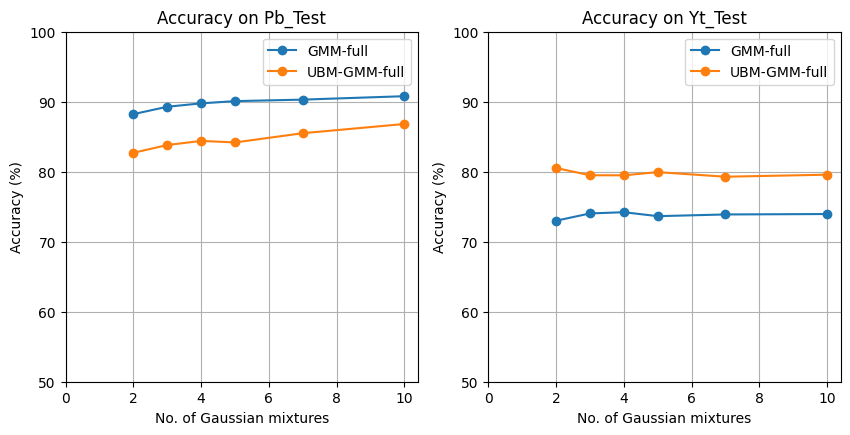

In [51]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.plot(no_of_clusters_full, accuracy_full_pb_test, marker='o',label='GMM-full')
plt.plot(no_of_clusters_ubm_full, accuracy_ubm_full_pb_test, marker='o', label='UBM-GMM-full')
ax.set(title=f"Accuracy on Pb_Test",
         xlabel="No. of Gaussian mixtures",
         ylabel="Accuracy (%)")
plt.grid()
plt.legend()
plt.yticks(range(50, 101, 10))
plt.xticks(range(0, no_of_clusters_full[-1]+1, 2))
# yt_test
ax = plt.subplot(2, 2, 2)
plt.plot(no_of_clusters_full, accuracy_full_yt_test, marker='o',label='GMM-full')
plt.plot(no_of_clusters_ubm_full, accuracy_ubm_full_yt_test, marker='o', label='UBM-GMM-full')
ax.set(title=f"Accuracy on Yt_Test",
         xlabel="No. of Gaussian mixtures",
         ylabel="Accuracy (%)")
plt.xticks(range(0, no_of_clusters_full[-1]+1, 2))

plt.yticks(range(50, 101, 10))
plt.grid()
plt.legend()
plt.show()

         |****** Performance of GMM with full Covariance on Pb_Test *******************| 


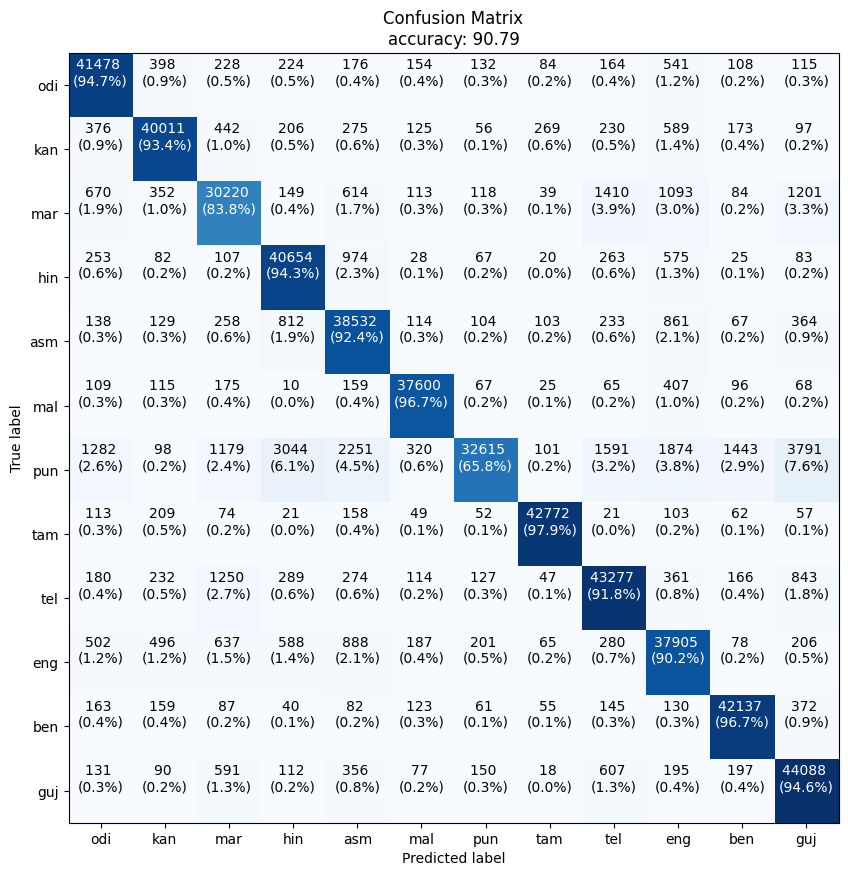

In [52]:
print('         |****** Performance of GMM with full Covariance on Pb_Test *******************| ')
make_confusion_matrix(y_pb_test, pred_label_full_pb, classes=languages, figsize=(10, 10)) # plot confusion matrix for bestmodel